# Objective 2.2 (model running)
1. Create new dataset (done in Objective 2.1)
2. EDA & Perform standardised PCA with SVM
3. Run predictive models & Test outlier sensitivity
4. Conclusion

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline

In [2]:
# Load the dataset
file_path = 'final.csv'  # Update with the actual file path
data = pd.read_csv(file_path)

# Drop non-numeric columns and rows with missing values for simplicity
data_clean = data.drop(columns=['Title']).dropna()

## 2. Perform SVM with Pipeline & Visualise with SVM

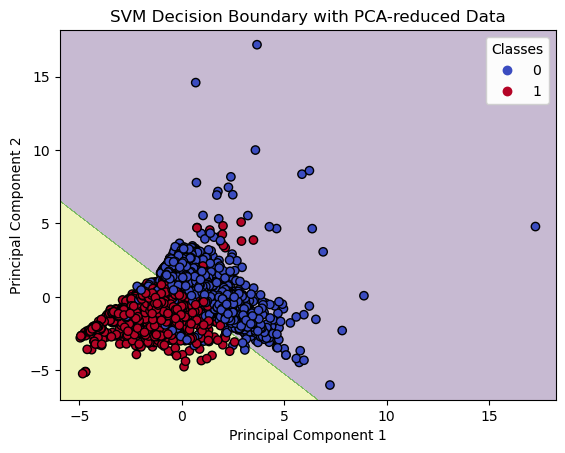

In [3]:
# Define features and target variable
X = data_clean.drop(columns=['Retraction'])
y = data_clean['Retraction']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the pipeline steps for SVM
pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', SVC(kernel='linear', random_state=42))
])

# Train the SVM model using the pipeline
pipeline_svm.fit(X_train, y_train)

# Extract the PCA-transformed data for plotting and decision function
X_train_pca = pipeline_svm.named_steps['pca'].transform(pipeline_svm.named_steps['scaler'].transform(X_train))
X_test_pca = pipeline_svm.named_steps['pca'].transform(pipeline_svm.named_steps['scaler'].transform(X_test))
svm_model_pca = pipeline_svm.named_steps['classifier']

# Plot the decision boundary
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3)
    
    # Plot the data points with labels
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm, label=y)
    legend = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend)
    
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('SVM Decision Boundary with PCA-reduced Data')
    plt.show()

plot_decision_boundary(X_train_pca, y_train, svm_model_pca)

### 2.1 SVM Outlier sensitivity
As SVM is sensitive to outliers, we test whether outliers have an impact on SVM accuracy.

In [16]:
# Get the decision function values
decision_values = svm_model_pca.decision_function(X_train_pca)

# Identify outliers based on the decision function values
threshold = 2  # Define a threshold for outliers
outliers = np.abs(decision_values) > threshold
outlier_proportion = np.mean(outliers)

print(f"Proportion of outliers: {outlier_proportion * 100:.2f}%")

# Evaluate the model with and without outliers
# Train a model without outliers
X_train_no_outliers = X_train_pca[~outliers]
y_train_no_outliers = y_train.iloc[~outliers]

svm_model_no_outliers = SVC(kernel='linear', random_state=42)
svm_model_no_outliers.fit(X_train_no_outliers, y_train_no_outliers)

# Predictions and evaluation
y_pred_with_outliers = svm_model_pca.predict(X_test_pca)
y_pred_no_outliers = svm_model_no_outliers.predict(X_test_pca)

accuracy_with_outliers = accuracy_score(y_test, y_pred_with_outliers)
accuracy_no_outliers = accuracy_score(y_test, y_pred_no_outliers)

report_with_outliers = classification_report(y_test, y_pred_with_outliers, digits=4)
report_no_outliers = classification_report(y_test, y_pred_no_outliers, digits=4)

print("Accuracy with outliers:", accuracy_with_outliers)
print("Accuracy without outliers:", accuracy_no_outliers)

print("Classification report with outliers:\n", report_with_outliers)
print("Classification report without outliers:\n", report_no_outliers)

Proportion of outliers: 55.05%
Accuracy with outliers: 0.9305439330543933
Accuracy without outliers: 0.9401673640167364
Classification report with outliers:
               precision    recall  f1-score   support

           0     0.9255    0.9419    0.9336      1239
           1     0.9362    0.9183    0.9272      1151

    accuracy                         0.9305      2390
   macro avg     0.9308    0.9301    0.9304      2390
weighted avg     0.9306    0.9305    0.9305      2390

Classification report without outliers:
               precision    recall  f1-score   support

           0     0.9477    0.9362    0.9419      1239
           1     0.9322    0.9444    0.9383      1151

    accuracy                         0.9402      2390
   macro avg     0.9400    0.9403    0.9401      2390
weighted avg     0.9403    0.9402    0.9402      2390



Despite a high proportion of outliers, accuracy shows minimal increase in accuracy, and SVM without outliers performs better.

## 3. Run predictive models
- Naive Bayes - baseline
- Logistic Regression: For a simple and interpretable model.
- Decision Trees: For understanding feature interactions and decision rules.
- Random Forest: For robustness and handling non-linear relationships.
- Gradient Boosting Machines: For high predictive accuracy and handling complex patterns.
- SVC with a Non-Linear Kernel: For capturing complex, non-linear relationships.

In [19]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

### 3.1 Set up Data Pipeline for all models

In [24]:
pipeline_nb = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', GaussianNB())
])

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline_gbm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

pipeline_svc = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', SVC(kernel='rbf', random_state=42))
])

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('classifier', KNeighborsClassifier())
])

### 3.2 Run all models and compare results

In [25]:
# Load and preprocess the data
numeric_data = data.drop(columns=['Title'])
X = numeric_data.drop(columns=['Retraction'])
y = numeric_data['Retraction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to train and evaluate models
def evaluate_model(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    return classification_report(y_test, y_pred, output_dict=True)

# Define and evaluate all pipelines
pipelines = {
    "Naive Bayes": pipeline_nb,
    "Logistic Regression": pipeline_lr,
    "Decision Tree": pipeline_dt,
    "Random Forest": pipeline_rf,
    "Gradient Boosting Machines": pipeline_gbm,
    "SVC with Non-Linear Kernel": pipeline_svc,
    "KNeighbors Classifier": pipeline_knn
}

reports = {}
for name, pipeline in pipelines.items():
    reports[name] = evaluate_model(pipeline, X_train, X_test, y_train, y_test)

# Convert reports to dataframes
report_dfs = {name: pd.DataFrame(report).transpose() for name, report in reports.items()}

# Display the classification reports for each model
for name, report_df in report_dfs.items():
    print(f"Classification Report for {name}:\n")
    print(report_df)
    print("\n")

Classification Report for Naive Bayes:

              precision    recall  f1-score      support
0              0.907895  0.946731  0.926906  1239.000000
1              0.939891  0.896612  0.917741  1151.000000
accuracy       0.922594  0.922594  0.922594     0.922594
macro avg      0.923893  0.921671  0.922324  2390.000000
weighted avg   0.923304  0.922594  0.922493  2390.000000


Classification Report for Logistic Regression:

              precision    recall  f1-score      support
0              0.925079  0.946731  0.935780  1239.000000
1              0.941176  0.917463  0.929168  1151.000000
accuracy       0.932636  0.932636  0.932636     0.932636
macro avg      0.933128  0.932097  0.932474  2390.000000
weighted avg   0.932831  0.932636  0.932596  2390.000000


Classification Report for Decision Tree:

              precision    recall  f1-score      support
0              0.926435  0.924939  0.925687  1239.000000
1              0.919341  0.920938  0.920139  1151.000000
accuracy   

### 3.3 Model accuracy comparison

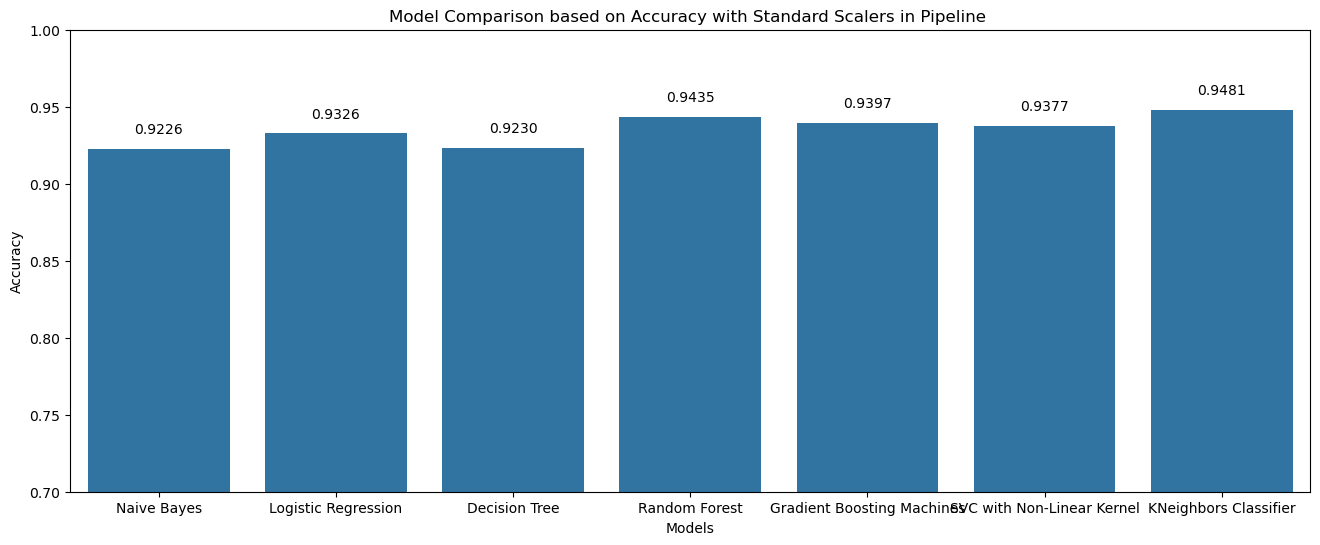

In [28]:
# Extract accuracy for each model and visualize
accuracies = {name: report['accuracy'] for name, report in reports.items()}
accuracy_df = pd.DataFrame.from_dict(accuracies, orient='index', columns=['accuracy'])

# Plot the accuracy for comparison
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 6))
sns.barplot(x=accuracy_df.index, y=accuracy_df['accuracy'])
plt.title('Model Comparison based on Accuracy with Standard Scalers in Pipeline ')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1)

# Annotate the bars with accuracy values
for index, value in enumerate(accuracy_df['accuracy']):
    plt.text(index, value + 0.01, f"{value:.4f}", ha='center')

plt.show()


KNN performs best in all metrics.

### 3.4 Optimise KNeighborsClassifier with RandomizedSearchCV & GridSearchCV

In [11]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_neighbors': list(range(1, 31)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

# Implement RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline_knn, param_distributions=param_dist, n_iter=50, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Evaluate the best model from RandomizedSearchCV
best_random_model = random_search.best_estimator_
y_pred_random = best_random_model.predict(X_test)
print("Classification Report for KNeighborsClassifier with RandomizedSearchCV:\n")
print(classification_report(y_test, y_pred_random, digits=4))

Classification Report for KNeighborsClassifier with RandomizedSearchCV:

              precision    recall  f1-score   support

           0     0.9507    0.9492    0.9499      1239
           1     0.9454    0.9470    0.9462      1151

    accuracy                         0.9481      2390
   macro avg     0.9480    0.9481    0.9480      2390
weighted avg     0.9481    0.9481    0.9481      2390



In [12]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_neighbors': list(range(1, 11)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]
}

# Implement GridSearchCV
grid_search = GridSearchCV(pipeline_knn, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate the best model from GridSearchCV
best_grid_model = grid_search.best_estimator_
y_pred_grid = best_grid_model.predict(X_test)
print("Classification Report for KNeighborsClassifier with GridSearchCV:\n")
print(classification_report(y_test, y_pred_grid, digits=4))

Classification Report for KNeighborsClassifier with GridSearchCV:

              precision    recall  f1-score   support

           0     0.9478    0.9524    0.9501      1239
           1     0.9485    0.9435    0.9460      1151

    accuracy                         0.9481      2390
   macro avg     0.9481    0.9480    0.9480      2390
weighted avg     0.9481    0.9481    0.9481      2390



After optimisation, all metrics did not improve. 

### 3.5 Extract the most important features to paper retractions using RandomForest

Accuracy of Random Forest model: 0.999442119944212
Feature Importances:
                               Feature  Importance
5  Number of Retractions by Publishers    0.399618
9         Total Retractions by Authors    0.330073
6     Number of Retractions by Journal    0.124732
3                          Open Access    0.039091
2               Retraction Time (days)    0.038271
7                                  SJR    0.030386
0                                 Year    0.020831
4                    Number of Authors    0.014468
1                             Citation    0.002237
8                  Journal Discontinue    0.000292


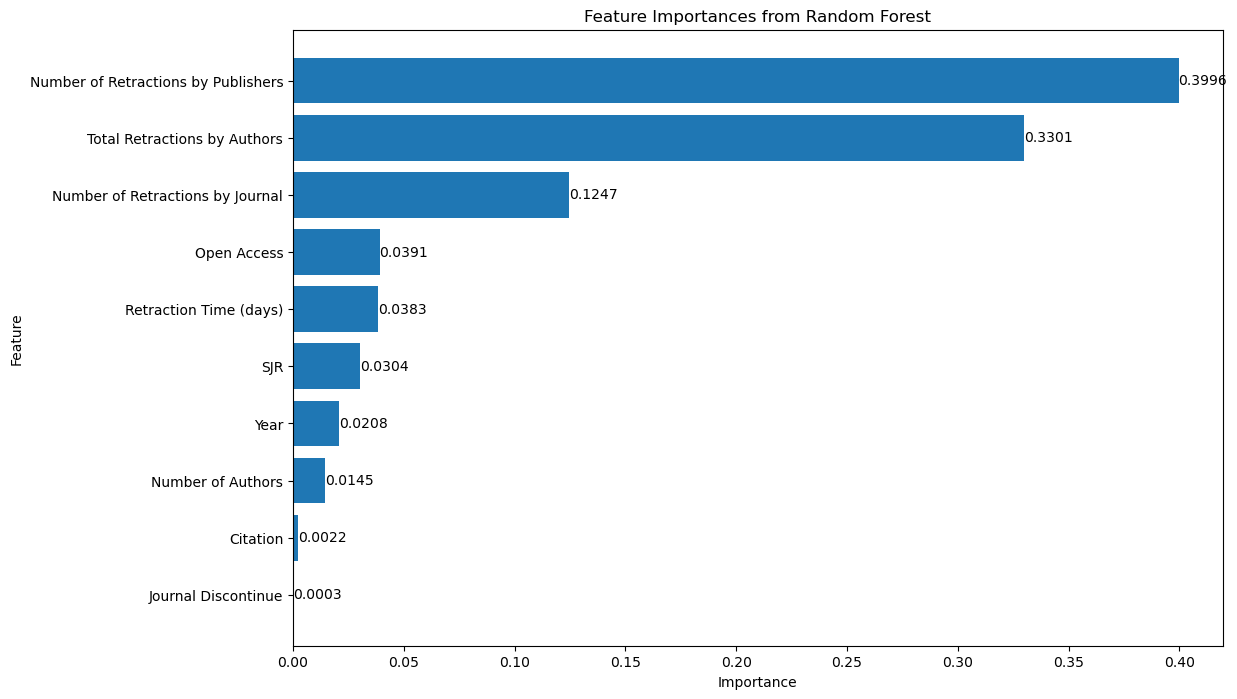

In [29]:
# Standardizing the original numeric data (excluding 'Retraction')
scaler = StandardScaler()
numeric_scaled_original = scaler.fit_transform(numeric_data.drop(columns=['Retraction']))

# Create a DataFrame of the scaled features
scaled_features_df = pd.DataFrame(numeric_scaled_original, columns=numeric_data.columns.drop(['Retraction']))

# Splitting the data into training and testing sets
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    scaled_features_df, numeric_data['Retraction'], test_size=0.3, random_state=42)

# Training the Random Forest model on original scaled features
random_forest_orig = RandomForestClassifier(random_state=42)
random_forest_orig.fit(X_train_orig, y_train_orig)

# Predicting the test set results
y_pred_rf_orig = random_forest_orig.predict(X_test_orig)

# Calculating the accuracy of the Random Forest model on original features
accuracy_rf_orig = accuracy_score(y_test_orig, y_pred_rf_orig)

# Getting feature importances
feature_importances = random_forest_orig.feature_importances_

# Creating a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': scaled_features_df.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Print the accuracy of the Random Forest model
print(f"Accuracy of Random Forest model: {accuracy_rf_orig}")

# Display the feature importance DataFrame
print("Feature Importances:")
print(feature_importance_df)

# Visualize the feature importances
plt.figure(figsize=(12, 8))
bars = plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  

for bar in bars:
    plt.text(
        bar.get_width(), 
        bar.get_y() + bar.get_height() / 2, 
        f'{bar.get_width():.4f}', 
        va='center'
    )

plt.show()

### 3.6 Retest with most important features for KNN

In [15]:
from sklearn.feature_selection import SelectFromModel

# Feature selection with RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Select the top features
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Train the KNN model using the selected features
knn = KNeighborsClassifier()
knn.fit(X_train_selected, y_train)

# Predicting the test set results
y_pred_knn = knn.predict(X_test_selected)

# Evaluate the model
print("Classification Report for KNeighborsClassifier with Selected Features:\n")
print(classification_report(y_test, y_pred_knn))

# Get the selected features
selected_features = X.columns[selector.get_support()]

# Display the selected features
print("Selected Features:")
print(selected_features)


Classification Report for KNeighborsClassifier with Selected Features:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1239
           1       0.99      0.98      0.98      1151

    accuracy                           0.98      2390
   macro avg       0.99      0.98      0.98      2390
weighted avg       0.98      0.98      0.98      2390

Selected Features:
Index(['Number of Retractions by Publishers',
       'Number of Retractions by Journal', 'Total Retractions by Authors'],
      dtype='object')
